In [1]:
import numpy as np
import pandas as pd

In [2]:
class Dataset:
    def __init__(self, dataset_path=None):
        self.path = dataset_path

    def get_data(self):
        data = pd.read_csv(self.path).to_numpy()
        X, Y_str = data[:, :-1], data[:, -1]  # remove the target column from the input and extract our targets
        # n_classes = len(set(Y_str))
        n_examples = len(Y_str)
        Y = np.zeros(n_examples)
        for i in range(len(Y_str)):
            category = Y_str[i]
            if category == "banana": Y[i] = 0
            elif category == "carrot": Y[i] = 1
            elif category == "cucumber": Y[i] = 2
            elif category == "mandarin": Y[i] = 3
            else: Y[i] = 4
        return X, Y


In [3]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iters=1000):
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.weights = None
        self.bias = None
        self.loss_hist = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict_raw(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def predict_proba(self, X):
        return self.sigmoid(self.predict_raw(X))
    
    def logisticLoss(self, y_true, y_pred):
        """
            binary cross entropy
        """
        y0 = y_true * np.log(y_pred)
        y1 = (1 - y_true) * np.log(1 - y_pred)
        return -np.mean(y0 + y1)
    
    def train(self, X_train, Y_train, X_val=None, Y_val=None):
        # Set the proper data type to avoid errors with numpy
        X_train, Y_train = X_train.astype(float), Y_train.astype(float)
        X_val = X_val.astype(float) if X_val is not None else None
        Y_val = Y_val.astype(float) if Y_val is not None else None
        # Normalize the features
        X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
        X_val   = (X_val - X_val.mean(axis=0)) / X_val.std(axis=0)


        n_examples, n_features = X_train.shape

        self.weights        = np.zeros(n_features)
        self.bias           = 0
        self.loss_hist      = []
        self.val_loss_hist  = []
        
        for i in range(self.num_iters):
            # Forward
            y_pred = self.sigmoid(np.dot(X_train, self.weights) + self.bias)
            train_loss = self.logisticLoss(Y_train, y_pred)

            # gradient of binary cross entropy
            y_diff = (y_pred - Y_train)
            self.weights -= self.learning_rate * np.dot(X_train.T, y_diff) / n_examples
            self.bias    -= self.learning_rate * np.mean(y_diff)
            
            # Save loss
            self.loss_hist.append(train_loss)

            # Validation
            if X_val is not None:
                val_pred = self.predict_proba(X_val)
                self.val_loss_hist.append(self.logisticLoss(Y_val, val_pred))

In [4]:
class LogisticRegressionOVA:
    def __init__(self, learning_rate=0.01, num_iters=1000):
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.models = []
        self.classes = None

    def train(self, X_train, Y_train, X_val=None, Y_val=None):
        self.classes = np.unique(Y_train)
        self.models = []

        for cls in self.classes:
            print(f"Train class {cls} vs rest")
            Y_binary_train  = (Y_train == cls).astype(float)
            Y_binary_val    = (Y_val == cls).astype(float) if Y_val is not None else None
            
            model = LogisticRegression(learning_rate=self.learning_rate, num_iters=self.num_iters)
            model.train(X_train, Y_binary_train, X_val, Y_binary_val)
            self.models.append(model)

    def predict(self, X):
        # Data type and normalization
        X = X.astype(float)
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        all_probs = []

        for model in self.models:
            probs = model.predict_proba(X)
            all_probs.append(probs)

        all_probs = np.column_stack(all_probs)
        max_idx = np.argmax(all_probs, axis=1)
        return self.classes[max_idx]

In [5]:
import matplotlib.pyplot as plt

def plot_ova_loss(models, classes):
    plt.figure(figsize=(10, 6))

    for model, cls in zip(models, classes):
        plt.plot(model.loss_hist, label=f"Train Loss (class {cls})")
        if len(model.val_loss_hist) > 0:
            plt.plot(model.val_loss_hist, '--', label=f"Val Loss (class {cls})")

    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss (One-vs-All)")
    plt.legend()
    plt.grid()
    plt.show()


Train class 0.0 vs rest
Train class 1.0 vs rest
Train class 2.0 vs rest
Train class 3.0 vs rest
Train class 4.0 vs rest


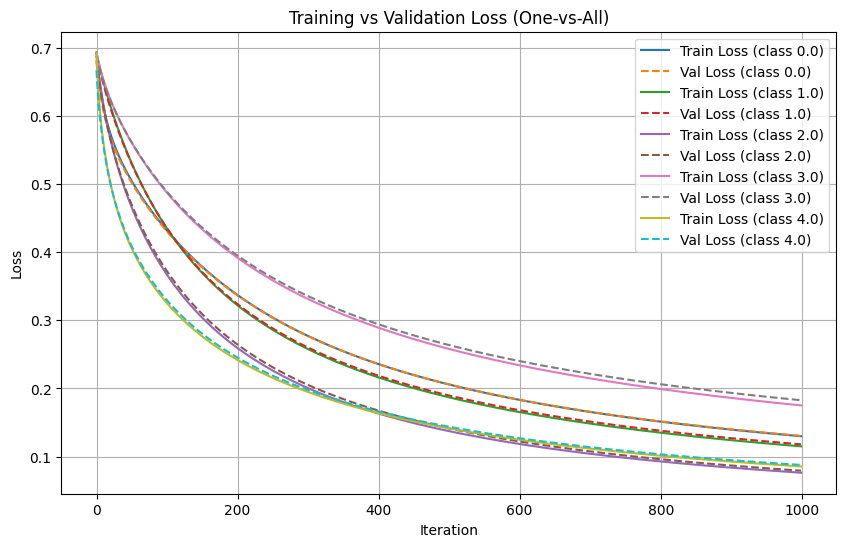

In [6]:
# Load splits
dataset = Dataset("./data/tabular/train_processed.csv")
X_train, Y_train = dataset.get_data()

dataset = Dataset("./data/tabular/validation_processed.csv")
X_val, Y_val = dataset.get_data()

dataset = Dataset("./data/tabular/test_processed.csv")
X_test, Y_test = dataset.get_data()

# Train OVA logistic regression
model_ova = LogisticRegressionOVA(learning_rate=0.01, num_iters=1000)
model_ova.train(X_train, Y_train, X_val, Y_val)

# Plot losses
plot_ova_loss(model_ova.models, model_ova.classes)

# Predictions
pred_train = model_ova.predict(X_train)
pred_val   = model_ova.predict(X_val)
pred_test  = model_ova.predict(X_test)
